In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from skbio.stats.composition import clr, centralize, alr_inv
from skbio.stats.composition import clr_inv as softmax
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator

from src.generators import ground_truth_edges
from src.evaluate import _edge_roc_curve
from biom import load_table
from scipy.stats import spearmanr, pearsonr

from skbio import OrdinationResults
from scipy.sparse.linalg import svds
import glob
#import yaml
%matplotlib inline

# Create ordination objects for each paired analysis

In [2]:
mmvec_dir = (
    '../results/ihmp_output/mmvec_results/tfrun1_taxa_filtered.biom_results/'
    'summary_%s_tfrun1_dim3_lr_beta10.9_beta20.95_sub_batch5000'
)
data_dir = '../data/ihmp'
results_dir = '../results/ihmp_output'
fnames = ['c18_neg.biom', 'c8_pos.biom', 'hilic_pos.biom', 'hilic_neg.biom']
microbes = load_table('../data/ihmp/taxa_filtered.biom')

def get_ranks(fname):
    metabolites = load_table('../data/ihmp/%s' % fname)
    U = np.loadtxt(os.path.join(mmvec_dir % fname, 'U.txt'))
    Ubias = np.loadtxt(os.path.join(mmvec_dir % fname, 'Ubias.txt'))
    V = np.loadtxt(os.path.join(mmvec_dir % fname, 'V.txt' ))
    Vbias = np.loadtxt(os.path.join(mmvec_dir % fname, 'Vbias.txt'))
    
    U = np.hstack((np.ones((U.shape[0], 1)), Ubias.reshape(-1, 1), U))
    V = np.vstack((Vbias, np.ones((1, V.shape[1])), V))
    ranks = pd.DataFrame(clr(centralize(alr_inv(U @ V))), 
                         index=microbes.ids(axis='observation'),
                         columns=metabolites.ids(axis='observation'))
    return ranks

def get_ordination(ranks):
    u, s, v = svds(ranks.values.T, k=3)

    scale = 3
    N = u.shape[0]
    # scale U matrix wrt to sqrt of eigenvalues
    u = u @ np.diag(s)
    # scale V matrix wrt to sqrt of eigenvalues
    v = (v).T
    samples = pd.DataFrame(u , index=ranks.columns)
    features = pd.DataFrame(v, index=ranks.index)
    #samples = samples.loc[set(samples.index) - {'C18n_QI06'}]
    res = OrdinationResults(
        'multiomics biplot', 'multiomics biplot',
        samples=pd.DataFrame(u , index=ranks.columns),
        features=pd.DataFrame(v, index=ranks.index),
        eigvals=pd.Series(s),
        proportion_explained=pd.Series(s / s.sum())
    )
    return res

rankz = list(map(get_ranks, fnames))
ords = list(map(get_ordination, rankz))
for i, o in enumerate(ords):
    o.write(os.path.join(results_dir, fnames[i]) + '.ordination.txt')

# Modify the feature metadata for each dataset

In [3]:
songbird_dir = '../results/ihmp_output/songbird_results'

taxa_diff = pd.read_table(
        os.path.join(songbird_dir,  
                     ('taxa_filtered.biom_prior5_songbird_results/'
                      'summary__dim_prior5_lr_beta10.9_beta20.95_sub_batch10/'
                      'differentials.tsv')
                    ), 
        index_col=0)

songbird_temp = os.path.join(songbird_dir,     
                 ('%s_prior0.1_songbird_results/summary__dim_prior0.1_lr_beta10.9_beta20.95_sub_batch10/'
                  'differentials.tsv')
                )

ms_annotations = pd.read_table('../data/ihmp/metabolite_annotations.txt', index_col=0)
songbird_files = list(map(lambda x: songbird_temp % x, fnames))
ms_diffs = list(map(lambda x: pd.read_table(x, index_col=0), songbird_files))

def merge_f(x):
    ms_metadata = pd.merge(ms_annotations, x, left_index=True, right_index=True)
    ms_metadata.index.name='sampleid'
    return ms_metadata

ms_mds = list(map(merge_f, ms_diffs))

for i, m in enumerate(ms_mds):
    m.to_csv(os.path.join(results_dir, fnames[i]) + '.metadata.txt', sep='\t')
    
taxa_diff.index.name='featureid'
taxa_diff.to_csv('../results/ihmp_output/microbe_metadata.txt', sep='\t')

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  if __name__ == '__main__':
/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  app.launch_new_instance()
/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


# Create a list of edges from the top 300 edges from the c18 and c8 analyses respectively

In [4]:
k = 500
crankz = list(map(lambda x: x - x.mean(axis=1).values.reshape(-1, 1), rankz))
edges = list(map(lambda x: pd.melt(x.reset_index(), id_vars='index'), crankz))
c18_edges = edges[0].sort_values('value', ascending=False).iloc[:k]
c8_edges = edges[1].sort_values('value', ascending=False).iloc[:k]
c18_c8_edges = pd.concat((c18_edges, c8_edges), axis=0)
c18_c8_edges = c18_c8_edges.rename(columns={'index': 'microbe', 'variable': 'metabolite', 'value': 'cond_logit'})
c18_c8_edges.set_index('microbe').to_csv('../results/ihmp_output/edges_%d.txt' % k, sep='\t')

In [5]:
r_hominis  = [
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_hominis',
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_hominis|t__GCF_000225345'
]

# emperor findings
actinomyces = [
    'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacteriaceae_unclassified'
    'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae',
    'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales',
    'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_5_1_63FAA',
    'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_catus',
    'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae',
]



gamma_proteobacteria = [
    'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales',
    'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria',
    'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_fragilis|t__Bacteroides_fragilis_unclassified',
    'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_uniformis|t__GCF_000154205',
    'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_pneumoniae',
    'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Klebsiella',    
    'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus',
    'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales',
    'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_parvula|t__Veillonella_parvula_unclassified',
    'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_coli|t__Escherichia_coli_unclassified',
    'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides|s__Parabacteroides_unclassified'
]

In [6]:
c818md = pd.concat((ms_mds[0], ms_mds[1]), axis=0)
c818md.to_csv('../results/ihmp_output/c18_c8_metadata.txt', sep='\t')

In [7]:
df = pd.merge(c18_c8_edges, c818md, left_on='metabolite', right_index=True)

In [8]:
df.to_csv('../results/ihmp_output/annotated_edges.txt', sep='\t')

In [9]:
ids = ['g__Propionibacteriaceae_unclassified',
       # 's__Desulfovibrio_desulfuricans',
       's__Klebsiella_pneumoniae',
       't__Klebsiella_pneumoniae_unclassified',
       'g__Klebsiella']
idx = list(map(lambda x: x in ids, list(map(lambda x: x.split('|')[-1], taxa_diff.index))))
select_microbes = taxa_diff.index[idx]

In [10]:
select_edges = c18_c8_edges.set_index('microbe').loc[select_microbes].sort_values('cond_logit', ascending=False)
select_edges = pd.merge(select_edges, c818md, left_on='metabolite', right_index=True)
select_edges.to_csv('../results/ihmp_output/select_edges.txt', sep='\t')

In [11]:
annotated = c818md['Metabolite']

In [12]:
annotated_lookup = set(annotated.dropna().index)

In [13]:
idx1 = edges[0].apply(lambda x: x['variable'] in annotated_lookup, axis=1)
idx2 = edges[1].apply(lambda x: x['variable'] in annotated_lookup, axis=1)
c18_edges = edges[0].loc[idx1]
c8_edges = edges[1].loc[idx2]

In [14]:
select_annotated_edges = pd.concat(
     (
         c18_edges.sort_values('value', ascending=False).iloc[:300],
         c8_edges.sort_values('value', ascending=False).iloc[:300]
     ), axis=0)

In [15]:
select_annotated_edges = select_annotated_edges.rename(columns={'index': 'microbe', 'variable': 'metabolite', 'value': 'cond_logit'})
select_annotated_edges.to_csv('../results/ihmp_output/select_annotated_edges.txt', sep='\t')

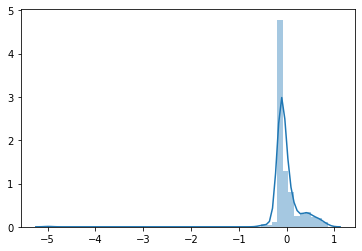

In [17]:
sns.distplot(taxa_diff['diagnosis[T.nonIBD]'].values)

In [18]:
taxa_diff['diagnosis[T.nonIBD]'].values.max()

0.8552214446016891

In [19]:
taxa_diff['diagnosis[T.nonIBD]'].values.min()

-4.981092279916132

In [20]:
microbes

562 x 387 <class 'biom.table.Table'> with 68227 nonzero entries (31% dense)

In [21]:
metabolites = load_table('../data/ihmp/%s' % fnames[0])

In [22]:
select_metabolites = pd.DataFrame({    
    'C18n_QI11520' : metabolites.data(id='C18n_QI11520', axis='observation'),
    'C18n_QI116' : metabolites.data(id='C18n_QI116', axis='observation')        
}, index=metabolites.ids(axis='sample'))

select_microbes = pd.DataFrame({    
    'Propionibacteriaceae' : microbes.data(id='k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacteriaceae_unclassified',
                                           axis='observation'),
    
    'Klebsiella' : microbes.data(id='k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_pneumoniae', 
                                    axis='observation')        
}, index=microbes.ids(axis='sample'))

# Validation

Let's now focus on the microbe-metabolite interactions mentioned in the paper.

In [25]:
# microbes
roseburia = list(taxa_diff.index[['Roseburia' in x for x in taxa_diff.index]])
klebsiella = list(taxa_diff.index[['Klebsiella' in x for x in taxa_diff.index]])
parainfluenzae = list(taxa_diff.index[['parainfluenze' in x for x in taxa_diff.index]])
bolteae = list(taxa_diff.index[['bolteae' in x for x in taxa_diff.index]])
# metabolites
compound_names0 = ms_mds[0]['Metabolite'].dropna()
compound_names1 = ms_mds[1]['Metabolite'].dropna()
bile_acids = list(compound_names0.index[[('cholate' in x) or ('cholic' in x) 
                                         for x in compound_names0.values]])
carnitines = list(compound_names1.index[['NH4_C' in x for x in compound_names1.values]])

In [26]:
microbe_ids = roseburia + klebsiella + parainfluenzae + bolteae

In [27]:
rankz0 = rankz[0].loc[microbe_ids, bile_acids]
rankz0.columns = ms_mds[0].loc[bile_acids, 'Metabolite'].values
rankz0.index = list(map(lambda x: x.split('|')[-1], microbe_ids))

rankz1 = rankz[1].loc[microbe_ids, carnitines]
rankz1.columns = ms_mds[1].loc[carnitines, 'Metabolite'].values
rankz1.index = list(map(lambda x: x.split('|')[-1], microbe_ids))

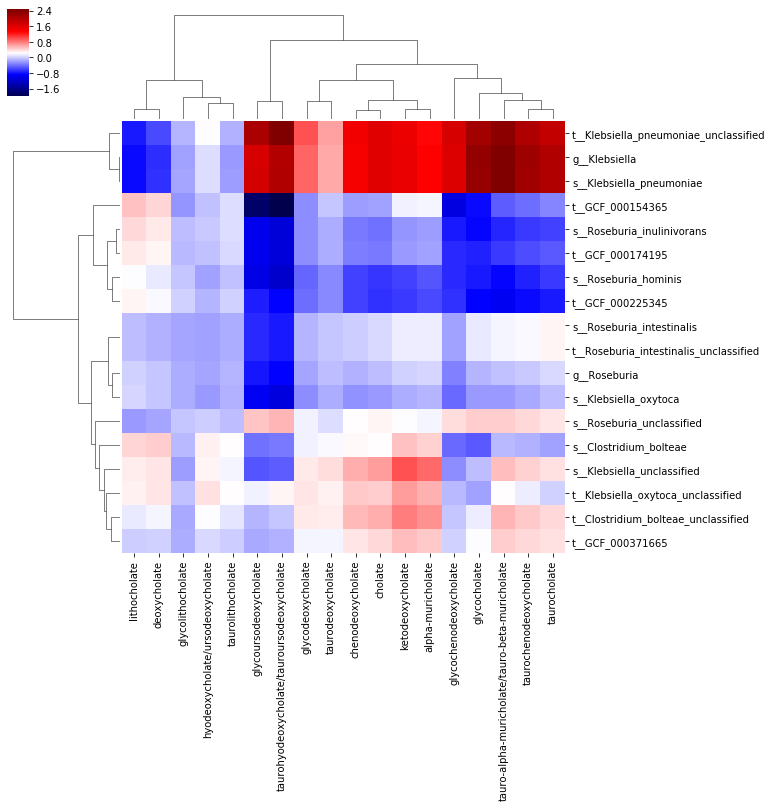

In [28]:
sns.clustermap(rankz0, cmap='seismic')

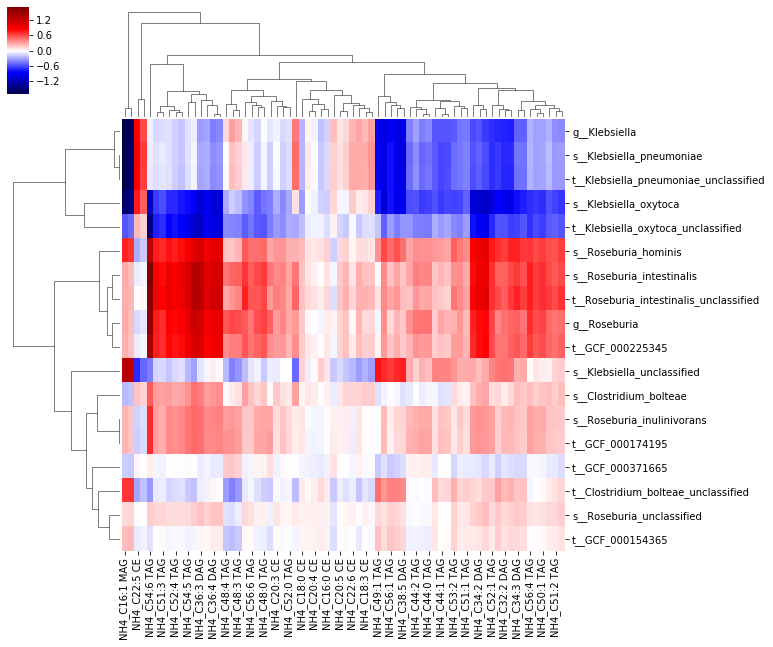

In [29]:
microbe_ids = roseburia + klebsiella + parainfluenzae + bolteae
sns.clustermap(rankz1, cmap='seismic')